<a href="https://colab.research.google.com/github/zingarelli/alura-challenges-data-science-2022/blob/main/Semana-3/Alura_Challenges_%7C_Data_Science_2022_Semana_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configurações e imports

In [126]:
# biblioteca para balanceio da target Churn
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached imbalanced_learn-0.9.1-py3-none-any.whl (199 kB)


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# para balanceamento do target
from imblearn.over_sampling import SMOTE

# para criação e validação dos modelos de machine learn
from sklearn.model_selection import train_test_split
from sklearn import metrics 
from sklearn.ensemble import RandomForestRegressor

# semente para garantir a replicabilidade do código
SEED = 12

In [128]:
# leitura da base tratada na Semana 1
df = pd.read_csv('https://raw.githubusercontent.com/zingarelli/alura-challenges-data-science-2022/main/Semana-1/analise_semana_1.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente_ID                      7043 non-null   object 
 1   cancelou_plano                  7043 non-null   object 
 2   genero                          7043 non-null   object 
 3   maior_65_anos                   7043 non-null   int64  
 4   possui_companheiro_companheira  7043 non-null   object 
 5   possui_dependentes              7043 non-null   object 
 6   meses_contrato                  7043 non-null   int64  
 7   assina_telefone                 7043 non-null   object 
 8   multiplas_linhas_telefonicas    7043 non-null   object 
 9   tipo_assinatura_internet        7043 non-null   object 
 10  adicional_seguranca_online      7043 non-null   object 
 11  adicional_backup_online         7043 non-null   object 
 12  adicional_protecao_dispositivo  70

# Encoding das variáveis categóricas

Irei aplicar o Label Encoding, como feito na [Semana 2](https://github.com/zingarelli/alura-challenges-data-science-2022/blob/main/Semana-2/Alura_Challenges_%7C_Data_Science_2022_Semana_02.ipynb). 

In [129]:
# função que transforma os valores categóricos de uma coluna em valores numéricos
def label_encoding(categorical_col):
  # altera o tipo de "object" para o tipo "category"
  encode = categorical_col.astype('category')

  # atribui a cada categoria um valor numérico diferente
  return encode.cat.codes

In [130]:
# copiando a base de dados
df_encoded = df.copy()

# colunas categóricas (sem o "cliente_ID", pois não será utilizada)
cat_columns = ['cancelou_plano', 'genero', 'possui_companheiro_companheira', 
               'possui_dependentes', 'assina_telefone', 'multiplas_linhas_telefonicas',
               'tipo_assinatura_internet', 'adicional_seguranca_online',
               'adicional_backup_online', 'adicional_protecao_dispositivo',
               'adicional_suporte_VIP', 'assina_TV_cabo', 'assina_streaming_filmes',
               'plano_contratado', 'fatura_online', 'forma_pagamento']

# aplicando o label encoding
for col in cat_columns:
  df_encoded[col] = label_encoding(df_encoded[col])

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   cliente_ID                      7043 non-null   object 
 1   cancelou_plano                  7043 non-null   int8   
 2   genero                          7043 non-null   int8   
 3   maior_65_anos                   7043 non-null   int64  
 4   possui_companheiro_companheira  7043 non-null   int8   
 5   possui_dependentes              7043 non-null   int8   
 6   meses_contrato                  7043 non-null   int64  
 7   assina_telefone                 7043 non-null   int8   
 8   multiplas_linhas_telefonicas    7043 non-null   int8   
 9   tipo_assinatura_internet        7043 non-null   int8   
 10  adicional_seguranca_online      7043 non-null   int8   
 11  adicional_backup_online         7043 non-null   int8   
 12  adicional_protecao_dispositivo  70

##TO DO: fazer One-Hot Encoding e analisar se melhoram os resultados dos modelos.

Rever curso Kaggle: https://www.kaggle.com/code/alexisbcook/categorical-variables


# Verificar se a variável target `Churn` está desbalanceada

Ver artigo: https://www.alura.com.br/artigos/lidando-com-desbalanceamento-dados

Ver documentação: https://imbalanced-learn.org/stable/introduction.html

Ver treinamento da Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106523

In [131]:
# armazenando os dados de cancelamento do plano em uma variável chamada churn
churn = df_encoded['cancelou_plano']

# separando entre clientes que estão ativos e aqueles que cancelaram o plano (former_customer)
# lembrando que o "Sim" significa que o cliente cancelou o plano
active_customers = (churn == 0).sum()
former_customers = (churn == 1).sum()
total_customers = len(churn)

print(f'Total de planos: {total_customers}')
print(f'Planos ativos: {active_customers}, {round(active_customers/total_customers*100, 2)}% do total')
print(f'Planos cancelados: {former_customers}, {round(former_customers/total_customers*100, 2)}% do total')

Total de planos: 7043
Planos ativos: 5174, 73.46% do total
Planos cancelados: 1869, 26.54% do total


Cerca de pouco mais de **um quarto da base** é formado por pessoas que **cancelaram** o plano (valor `1` na base), e o restante, de pessoas que mantiveram o plano (valor `0` na base). Isso faz com que a variável **target esteja desbalanceada**, o que pode **prejudicar** na criação dos modelos de Machine Learning. 

Desse modo, antes de criar os modelos é necessário fazer um balanceamento do target. 

Isso pode ser feito por meio do **oversampling**, isto é, criação de **novos dados (sintéticos) para aumentar** a quantidade de valores 1 na variável `cancelou_plano`, ou por meio do **undersampling**, isto é, selecionando na base **apenas alguns de registros** que possuam o valor 0 em `cancelou_plano`. Em ambas as estratégias, o objetivo e ter uma quantidade equivalente de registros com os valores 0 e 1.

## Estratégia de balanceamento 1: Oversampling
Utilizando o algoritmo SMOTE (KNN) para cópia de dados

In [132]:
# aplicando o random_state para garantir a replicabilidade do código
smote = SMOTE(random_state = SEED)

# separando as variáveis de treino e target
# client_ID também foi removida, pois não será utilizada na modelagem (é só um identificador)
x = df_encoded.drop(['cancelou_plano', 'cliente_ID'], axis=1)
y = df_encoded['cancelou_plano']  

# aplicando a SMOTE e salvando os novos dados criados
x_oversmp, y_oversmp = smote.fit_resample(x, y)

In [133]:
# criando a base balanceada com oversampling
df_oversmp = pd.concat([y_oversmp, x_oversmp], axis=1)
df_oversmp.sample(5)

,cancelou_plano,genero,maior_65_anos,possui_companheiro_companheira,possui_dependentes,meses_contrato,assina_telefone,multiplas_linhas_telefonicas,tipo_assinatura_internet,adicional_seguranca_online,...,adicional_protecao_dispositivo,adicional_suporte_VIP,assina_TV_cabo,assina_streaming_filmes,plano_contratado,fatura_online,forma_pagamento,gasto_diario,gasto_mensal,gasto_total
3707,0,1,0,1,1,7,0,1,0,0,...,0,0,0,0,1,1,1,0.820000,24.700000,149.050000
2869,1,1,1,1,0,3,1,0,1,0,...,0,0,2,0,1,1,1,2.680000,80.400000,224.050000
2290,0,1,0,0,0,68,1,0,2,1,...,1,1,1,1,0,0,0,0.650000,19.600000,1441.650000
8150,1,0,0,0,0,4,1,2,1,0,...,0,0,0,0,1,1,1,2.504732,75.081411,321.300417
418,0,0,0,1,0,72,1,2,1,2,...,2,2,2,2,0,1,0,3.730000,111.900000,8071.050000


In [134]:
# verificando o balanceamento e comparando com a base original
print('Tamanho base original: ', df.shape)
print('Tamanho base com oversample: ', df_oversmp.shape)
print('Valores de churn:')
print(df_oversmp['cancelou_plano'].value_counts())

Tamanho base original:  (7043, 22)
Tamanho base com oversample:  (10348, 21)
Valores de churn:
0    5174
1    5174
Name: cancelou_plano, dtype: int64


## TO DO: Estratégia de balanceamento 2: Undersampling

# Criação dos modelos de Machine Learning

Ver treinamento Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106526

Rever curso Kaggle: 
> https://www.kaggle.com/code/dansbecker/your-first-machine-learning-model, 
> https://www.kaggle.com/code/dansbecker/random-forests

Ver código criado na Housing Prices Competition do Kaggle (precisa estar logado), leaderboard #12792: https://www.kaggle.com/code/zingarelli/ml-competitions-first-own-submission

Aula de ML da Imersão Dados 4 da Alura (talvez já não esteja disponível): https://www.youtube.com/watch?v=8VsqXXXHp8U

## Modelo 1: Random Forest

In [135]:
# função para criar o modelo e aplicar algumas métricas
# data: base de dados
# features: colunas a serem consideradas para o treino
# n_trees: número de árvores da floresta
# depth: faz a "poda" das árvores após atingir a profundidade (para evitar overfitting)
def random_forest_model(data, features, n_trees=100, depth=5):
  # separando target e features
  y = data['cancelou_plano']
  X = data[features]  

  # separando os dados de treino e validação (por padrão 25% dos dados para validação)
  X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)

  # criando o modelo 
  rf = RandomForestRegressor(random_state=SEED, n_estimators=n_trees, max_depth=depth)
  rf.fit(X_train, y_train)

  # predizendo os resultados e classificando entre 0 e 1
  y_pred = rf.predict(X_test)
  y_class = np.where(y_pred > 0.5, 1,0)

  # métricas de validação do modelo criado
  print('-'*40 + '\nResultados do Modelo\n' + '-'*40)
  print('Acurácia (acerto geral): ', metrics.accuracy_score(y_test, y_class))
  print('Precisão (acerto de quem cancelou o plano, dentre os positivos reais): ', metrics.precision_score(y_test, y_class))
  print('Recall (acerto de quem cancelou o plano, dentre todos os positivos): ', metrics.recall_score(y_test, y_class)) 
  print('F1 (média harmônica precisão e recall): ', metrics.f1_score(y_test, y_class))

  # plot da matriz de confusão
  cm = metrics.confusion_matrix(y_test, y_class)
  disp = metrics.ConfusionMatrixDisplay(cm)
  disp.plot()

----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7901043679938152
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.7691247415575465
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.8429003021148036
F1 (média harmônica precisão e recall):  0.8043243243243242
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7947429454967143
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.77439446366782
Recall (acerto de quem cancelou o plano, dentre todos os positivos):  0.845166163141994
F1 (média harmônica precisão e recall):  0.8082340195016251
----------------------------------------
Resultados do Modelo
----------------------------------------
Acurácia (acerto geral):  0.7967064168086314
Precisão (acerto de quem cancelou o plano, dentre os positivos reais):  0.66860

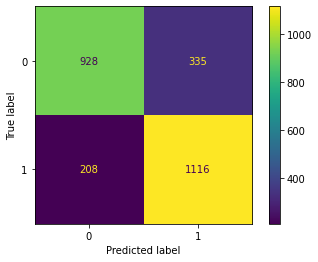

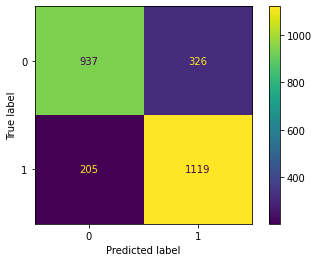

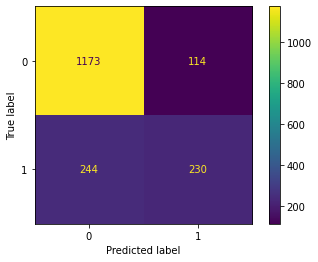

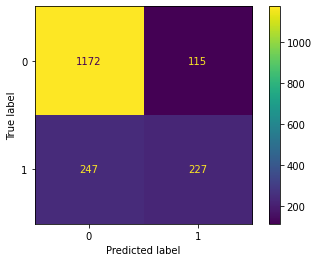

In [136]:
# escolhendo algumas colunas para o modelo
features = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato', 'plano_contratado']
features_2 = ['genero', 'maior_65_anos', 'gasto_mensal', 'meses_contrato', 'plano_contratado', 'possui_companheiro_companheira', 'possui_dependentes']

# testando o modelo com diferentes parâmetros e features
# usando a base de dados balanceada com oversampling
random_forest_model(df_oversmp, features, 150, 10)
random_forest_model(df_oversmp, features_2, 150, 10)

# mesmo teste, com a base de dados original
random_forest_model(df_encoded, features, 150, 10)
random_forest_model(df_encoded, features_2, 150, 10)

## TO DO: escolher o Modelo 2

# TO DO: análise de métricas e testar modelos com o outro tipo de encoding

Ver aula da Sthe: https://cursos.alura.com.br/course/modelos-preditivos-dados-deteccao-fraude/task/106629